<a href="https://colab.research.google.com/github/sjung-stat/Customer-Support-Chat-Intent-Classification/blob/main/Data%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the 'Exploratory Data Analysis' part, we found out that the dataset is imbalanced. We try to deal with the text data imbalance issue by


1. merging smiliar intents
      - There are too many categories relative to the size of the dataset we have. The best approach is to merge categories that have similar intents. Originally, there exist 77 different categories. But we group them into 13 subgroups based on their similarities. The reorganization process is described below.

2.   augmenting text data which belong to minority class
      - There are several methods to augment text data, including: 
          - back translation (e.g. English -> French -> English)
          - paraphrasing
      - We use paraphrasing, because most of the time, we noticed that back translation gives you almost the identical (even word by word) result before and after translation. Parapharsing, on the other hand, gives you a similar but not the same result as the original sentences. But, sometimes, the parapharsing technique even changes some important keywords, so that it doesn't seem to belong to the category anymore For example, when we apply technique to the 'contactless_not_working' category, the keyword 'contactless' translates to other words, so they can't be classifed to the cateogry anymore. In such cases, we either merge the class to similar categories, or remove the minority category when there are not enough data. After data augmentation, we examine whether there are exactly the same sentences in each of the category. If the same sentences are found, we only keep one of them. 

3.   removing text data which have similar meaning in each of the majority class. 
      - There are multiple ways you can calculate the text similarity. This [blog post](https://medium.com/@adriensieg/text-similarities-da019229c894) introduces 10+ different ways you can implement.
      - Among the many different options, we use __BERT embeddings + Cosine Similarity__ method. 
        - BERT produces contextualized word embeddings, meaning that each word's embedding is generated based on the context it appears in, rather than simply being a fixed representation of the word. This allows BERT to capture the nuances of meaning that can be missed by simpler word embedding models.

        - To calculate word similarity using BERT embeddings, you can use cosine similarity to compare the embeddings of two words. Cosine similarity measures the angle between two vectors and returns a value between -1 and 1, where 1 means the vectors are identical and -1 means they are completely dissimilar.






# Import Data

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import pickle

drive.mount('/content/drive') # Mount Google Drive to Colab


url_training = 'https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv'
url_testing = 'https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/test.csv'
df_training = pd.read_csv(url_training)
df_testing = pd.read_csv(url_testing)

# In order to preserve the original training data, we create a copy of the dataset. 
df_training_copy = df_training.copy()
df_testing_copy = df_testing.copy()

Mounted at /content/drive


# Merging Similar Intents

> Due to the limited amount of data in each of the 77 categories, the accuracy of the classification model would likely be low. To address this, we have created 13 new categories by grouping similar categories together. These new categories will be used in the classification model instead of the original 77 categories.



*   Account Management
    *   card_linking
    *   apple_pay_or_google_pay
    *   change_pin
    *   edit_personal_details    
    *   verify_source_of_funds    
    *   age_limit   
    *   terminate_account
    *   compromised_card

*   Card Issues
    *   activate_my_card
    *   card_arrival
    *   visa_or_mastercard
    *   card_about_to_expire
    *   disposable_card_limits
    *   lost_or_stolen_card    
    *   card_not_working    
    *   virtual_card_not_working   
    *   contactless_not_working

*   Currency and Country Support
    *   supported_cards_and_currencies
    *   country_support
    *   fiat_currency_support
    *   exchange_charge
    *   exchange_via_app
    *   exchange_rate

*   Fees and charges
    *   card_payment_fee_charged    
    *   cash_withdrawal_charge    
    *   transfer_fee_charged   
    *   extra_charge_on_statement

*   Identity Verification Issues
    *   why_verify_identity
    *   pin_blocked
    *   passcode_forgotten
    *   verify_my_identity
    *   unable_to_verify_identity


*   Miscellaneous Issues
    *   beneficiary_not_allowed
    *   lost_or_stolen_phone    
    *   card_delivery_estimate    
    *   atm_support   
    *   card_swallowed
    *   card_acceptance

*   New Cards
    *   getting_spare_card
    *   order_physical_card
    *   get_physical_card
    *   getting_virtual_card
    *   get_disposable_virtual_card

*   Payment Issues
    *   direct_debit_payment_not_recognised
    *   card_payment_not_recognised
    *   card_payment_wrong_exchange_rate
    *   reverted_card_payment?
    *   pending_card_payment
    *   declined_card_payment

*   Refunds and cancellations
    *   request_refund
    *   Refund_not_showing_up
    *   cancel_transfer

*   Top-Up Issues
    *   pending_top_up
    *   top_up_reverted
    *   top_up_failed
    *   automatic_top_up
    *   verify_top_up
    *   top_up_by_cash_or_cheque
    *   top_up_by_card_charge
    *   top_up_by_bank_transfer_charge
    *   topping_up_by_card
    *   top_up_limits

*   Transaction Issues
    *   balance_not_updated_after_cheque_or_cash_deposit
    *   wrong_amount_of_cash_received
    *   transaction_charged_twice
    *   receiving_money

*   Transfer Issues
    *   transfer_not_received_by_recipient
    *   balance_not_updated_after_bank_transfer
    *   pending_transfer
    *   failed_transfer
    *   declined_transfer
    *   transfer_timing
    *   transfer_into_account

*   Withdrawal Issues
    *   declined_cash_withdrawal
    *   wrong_exchange_rate_for_cash_withdrawal
    *   cash_withdrawal_not_recognised
    *   pending_cash_withdrawal

In [ ]:
df_training_copy.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [ ]:
def category_manipulate(df):

  # 1: Account Management
  category_Account_Management = ['card_linking','apple_pay_or_google_pay','change_pin','edit_personal_details',
                                 'verify_source_of_funds','age_limit','terminate_account','compromised_card']
  mask_Account_Management = df['category'].isin(category_Account_Management)
  df.loc[mask_Account_Management, 'category'] = 'Account_Management'


  # 2: Card Issues
  category_Card_Issues = ['activate_my_card','card_arrival','visa_or_mastercard','card_about_to_expire','disposable_card_limits',
                          'card_not_working','lost_or_stolen_card','virtual_card_not_working','contactless_not_working']
  mask_Card_Issues = df['category'].isin(category_Card_Issues)
  df.loc[mask_Card_Issues, 'category'] = 'Card_Issues'


  # 3: Currency and Country Support
  category_Currency_and_Country_Support = ['supported_cards_and_currencies','country_support','fiat_currency_support',
                                           'exchange_charge','exchange_via_app','exchange_rate']
  mask_Currency_and_Country_Support = df['category'].isin(category_Currency_and_Country_Support)
  df.loc[mask_Currency_and_Country_Support, 'category'] = 'Currency_and_Country_Support'


  # 4: Fees and charges
  category_Fees_and_charges = ['card_payment_fee_charged','cash_withdrawal_charge','transfer_fee_charged','extra_charge_on_statement']
  mask_Fees_and_charges = df['category'].isin(category_Fees_and_charges)
  df.loc[mask_Fees_and_charges, 'category'] = 'Fees_and_charges'


  # 5: Identity Verification Issues
  category_Identity_Verification_Issues = ['why_verify_identity','pin_blocked','passcode_forgotten','verify_my_identity','unable_to_verify_identity']
  mask_Identity_Verification_Issues = df['category'].isin(category_Identity_Verification_Issues)
  df.loc[mask_Identity_Verification_Issues, 'category'] = 'Identity_Verification_Issues'


  # 6: Miscellaneous Issues
  category_Miscellaneous_Issues = ['beneficiary_not_allowed','lost_or_stolen_phone','card_delivery_estimate','atm_support','card_swallowed','card_acceptance']
  mask_Miscellaneous_Issues = df['category'].isin(category_Miscellaneous_Issues)
  df.loc[mask_Miscellaneous_Issues, 'category'] = 'Miscellaneous_Issues'


  # 7: New Cards
  category_New_Cards = ['getting_spare_card','order_physical_card','get_physical_card','getting_virtual_card','get_disposable_virtual_card']
  mask_New_Cards = df['category'].isin(category_New_Cards)
  df.loc[mask_New_Cards, 'category'] = 'New_Cards'


  # 8: Payment Issues
  category_Payment_Issues = ['direct_debit_payment_not_recognised','card_payment_not_recognised','card_payment_wrong_exchange_rate',
                             'reverted_card_payment?','pending_card_payment','declined_card_payment']
  mask_Payment_Issues = df['category'].isin(category_Payment_Issues)
  df.loc[mask_Payment_Issues, 'category'] = 'Payment_Issues'


  # 9: Refunds and cancellations
  category_Refunds_and_cancellations = ['request_refund','Refund_not_showing_up','cancel_transfer']
  mask_Refunds_and_cancellations = df['category'].isin(category_Refunds_and_cancellations)
  df.loc[mask_Refunds_and_cancellations, 'category'] = 'Refunds_and_cancellations'


  # 10: Top-Up Issues
  category_TopUp_Issues = ['pending_top_up','top_up_reverted','top_up_failed','automatic_top_up','verify_top_up','top_up_by_cash_or_cheque',
                           'top_up_by_card_charge','top_up_by_bank_transfer_charge','topping_up_by_card','top_up_limits']
  mask_TopUp_Issues = df['category'].isin(category_TopUp_Issues)
  df.loc[mask_TopUp_Issues, 'category'] = 'TopUp_Issues'


  # 11: Transaction Issues 
  category_Transaction_Issues = ['balance_not_updated_after_cheque_or_cash_deposit','wrong_amount_of_cash_received','transaction_charged_twice','receiving_money']
  mask_Transaction_Issues = df['category'].isin(category_Transaction_Issues)
  df.loc[mask_Transaction_Issues, 'category'] = 'Transaction_Issues'


  # 12: Transfer Issues
  category_Transfer_Issues = ['transfer_not_received_by_recipient','balance_not_updated_after_bank_transfer','pending_transfer','failed_transfer',
                              'declined_transfer','transfer_timing','transfer_into_account']
  mask_Transfer_Issues = df['category'].isin(category_Transfer_Issues)
  df.loc[mask_Transfer_Issues, 'category'] = 'Transfer_Issues'


  # 13: Withdrawal Issues
  category_Withdrawal_Issues = ['declined_cash_withdrawal','wrong_exchange_rate_for_cash_withdrawal','cash_withdrawal_not_recognised','pending_cash_withdrawal']
  mask_Withdrawal_Issues = df['category'].isin(category_Withdrawal_Issues)
  df.loc[mask_Withdrawal_Issues, 'category'] = 'Withdrawal_Issues'

  return df

In [ ]:
df_training_copy = category_manipulate(df_training_copy)
df_testing_copy = category_manipulate(df_testing_copy)

In [ ]:
df_training_copy_count = df_training_copy.groupby(['category'])['category'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df_training_copy_count

,category,count
9,TopUp_Issues,1232
11,Transfer_Issues,1001
7,Payment_Issues,990
1,Card_Issues,967
0,Account_Management,925
2,Currency_and_Country_Support,735
3,Fees_and_charges,702
12,Withdrawal_Issues,639
10,Transaction_Issues,631
5,Miscellaneous_Issues,596


In [ ]:
df_testing_copy_count = df_testing_copy.groupby(['category'])['category'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df_testing_copy_count

,category,count
9,TopUp_Issues,400
1,Card_Issues,360
0,Account_Management,320
11,Transfer_Issues,280
2,Currency_and_Country_Support,240
5,Miscellaneous_Issues,240
7,Payment_Issues,240
4,Identity_Verification_Issues,200
6,New_Cards,200
3,Fees_and_charges,160


# Data Augmentation

In [ ]:
# Install and import necessary libraries required for paraphasing and translating text data 

! pip install -q sentence-splitter
! pip install -q transformers
! pip install -q SentencePiece
! pip install -q mtranslate

from mtranslate import translate
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from sentence_splitter import SentenceSplitter, split_text_into_sentences

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Paraphrasing

In [ ]:
# Hugging Face provides the following function which paraphrases a sentence. 
# https://huggingface.co/tuner007/pegasus_paraphrase

model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

def get_response(input_text,num_return_sequences):
  batch = tokenizer.prepare_seq2seq_batch([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
  translated = model.generate(**batch,max_length=60,num_beams=10, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
def df_paraphrase(df, cols, num_return_sequences=1):

  # create an empty dataframe with columns text and category
  df_training_augment = pd.DataFrame(columns=['text', 'category'])

  for cat_names in cols:
    mask = df_training_copy['category'] == cat_names
    training_augment = df_training_copy[mask].text.apply(lambda x: " ".join(get_response(x, 1)))
    df_training_augment_temp = training_augment.to_frame().assign(category=cat_names)
    df_training_augment = df_training_augment.append(df_training_augment_temp)

  return df_training_augment

In [ ]:
# Paraphrase the 8 categories that have the least number of data

categories_minority_8 = df_training_copy_count.category[-8:,].tolist()
categories_minority_8

['Currency_and_Country_Support',
 'Fees_and_charges',
 'Withdrawal_Issues',
 'Transaction_Issues',
 'Miscellaneous_Issues',
 'New_Cards',
 'Identity_Verification_Issues',
 'Refunds_and_cancellations']

In [ ]:
df_parapharse_8 = df_paraphrase(df = df_training_copy, cols = categories_minority_8, num_return_sequences=1)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3707: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


In [ ]:
with open('/content/drive/MyDrive/df_parapharse_8.pkl', 'wb') as f:   # Save to Google Drive
    pickle.dump(df_parapharse_8, f)   # pickle.dump(X, f) saves the preprocessed data X to a file called preprocessed_data.pkl in the root directory of your Google Drive.

In [ ]:
"""
# 3. Load preprocessed data from Google Drive:

with open('/content/drive/MyDrive/df_parapharse_8.pkl', 'rb') as f:   # Load `df_parapharse_8` from Google Drive
    df_parapharse_8 = pickle.load(f)
    """

In [ ]:
"""
df_parapharse_8.head()
"""

,text,category
292,What is the value of my money in other countries?,Currency_and_Country_Support
293,Will my money be worth the same when I travel ...,Currency_and_Country_Support
294,Do you know the exchange rate?,Currency_and_Country_Support
295,"On weekdays and the weekends, what foreign exc...",Currency_and_Country_Support
296,What is the exchange looking like?,Currency_and_Country_Support


## Back Translation

In [ ]:
# Back translation (to avoid the situation where translation gives you back the same output as input, we use 3-way translation which makes the translation more complicated: it -> ru -> en)

def df_back_translation(df, cols):

  # create an empty dataframe with columns text and category
  df_training_augment = pd.DataFrame(columns=['text', 'category'])

  for cat_names in cols:
    mask = df['category'] == cat_names
    df_translate_1 = df[mask].text.apply(lambda x: translate(x, "it"))
    df_translate_2 = df_translate_1.apply(lambda x: translate(x, "ru"))
    df_translate_3 = df_translate_2.apply(lambda x: translate(x, "en"))

    df_training_augment_temp = df_translate_3.to_frame().assign(category=cat_names)
    df_training_augment = df_training_augment.append(df_training_augment_temp)

  return df_training_augment

In [ ]:
"""
# When you back-translate more than 2 features at once, it gives you "HTTPError: HTTP Error 429: Too Many Requests" error message. 
# So, instead of using the function above for all 4 columns, we apply the functions one by one. 


# Back translate the 8 categories that have the least number of data

categories_minority_4 = df_training_copy_count.category[-4:,].tolist()
df_backtranslate_4 = df_back_translation(df = df_training_copy, cols = categories_minority_4)

"""

'\n# When you back-translate more than 2 features at once, it gives you "HTTPError: HTTP Error 429: Too Many Requests" error message. \n# So, instead of using the function above for all 4 columns, we apply the functions one by one. \n\n\n# Back translate the 8 categories that have the least number of data\n\ncategories_minority_4 = df_training_copy_count.category[-4:,].tolist()\ndf_backtranslate_4 = df_back_translation(df = df_training_copy, cols = categories_minority_4)\n\n'

In [ ]:
# Back translation (to avoid the situation where translation gives you back the same output as input, we use 3-way translation which makes the translation more complicated: it -> ru -> en)

mask = df_training_copy['category'] == 'Miscellaneous_Issues'

df_translate_1_training = df_training_copy[mask].text.apply(lambda x: translate(x, "it"))
df_translate_2_training = df_translate_1_training.apply(lambda x: translate(x, "ru"))
df_translate_3_training = df_translate_2_training.apply(lambda x: translate(x, "en"))

Miscellaneous_Issues_translated_training = df_translate_3_training.to_frame().assign(category="Miscellaneous_Issues")
Miscellaneous_Issues_translated_training

,text,category
1006,Is it possible to deliver on a specific date?,Miscellaneous_Issues
1007,I need to get a card quickly,Miscellaneous_Issues
1008,When can I expect my card? I live in USA.,Miscellaneous_Issues
1009,Help! When will the card arrive at my home?,Miscellaneous_Issues
1010,Can I get fast tracking on my card?,Miscellaneous_Issues
...,...,...
7156,I tried to make a bank transfer and it didn't ...,Miscellaneous_Issues
7157,I'm having trouble transferring money to a rec...,Miscellaneous_Issues
7158,"Why don't you accept my transfer, I keep getti...",Miscellaneous_Issues
7159,problems with beneficial transfer?,Miscellaneous_Issues


In [ ]:
# Back translation (to avoid the situation where translation gives you back the same output as input, we use 3-way translation which makes the translation more complicated: it -> ru -> en)

mask = df_training_copy['category'] == 'New_Cards'

df_translate_1_training = df_training_copy[mask].text.apply(lambda x: translate(x, "it"))
df_translate_2_training = df_translate_1_training.apply(lambda x: translate(x, "ru"))
df_translate_3_training = df_translate_2_training.apply(lambda x: translate(x, "en"))

New_Cards_translated_training = df_translate_3_training.to_frame().assign(category="New_Cards")
New_Cards_translated_training

,text,category
2998,"I would like to order a virtual card, where ca...",New_Cards
2999,"I need to order a new virtual card, how can I ...",New_Cards
3000,How to register a virtual card?,New_Cards
3001,I haven't received my virtual card yet!!,New_Cards
3002,Can you give me a virtual card?,New_Cards
...,...,...
8463,"I need to top up my virtual card, how can I do...",New_Cards
8464,What are the benefits of a single use card?,New_Cards
8465,What is disposable paper?,New_Cards
8466,"I've heard about these one-time virtual cards,...",New_Cards


In [ ]:
"""
# Concatenate the "Miscellaneous_Issues" and "New_Cards" and pickle it.



df_training_augment_1 = pd.concat([Miscellaneous_Issues_translated_training, New_Cards_translated_training])

with open('/content/drive/MyDrive/df_training_augment_1.pkl', 'wb') as f:   # Save to Google Drive
    pickle.dump(df_training_augment_1, f)   # pickle.dump(X, f) saves the preprocessed data X to a file called preprocessed_data.pkl in the root directory of your Google Drive.
"""

In [ ]:
# Back translation (to avoid the situation where translation gives you back the same output as input, we use 3-way translation which makes the translation more complicated: it -> ru -> en)

mask = df_training_copy['category'] == 'Identity_Verification_Issues'

df_translate_1_training = df_training_copy[mask].text.apply(lambda x: translate(x, "it"))
df_translate_2_training = df_translate_1_training.apply(lambda x: translate(x, "ru"))
df_translate_3_training = df_translate_2_training.apply(lambda x: translate(x, "en"))

Identity_Verification_Issues_translated_training = df_translate_3_training.to_frame().assign(category="Identity_Verification_Issues")
Identity_Verification_Issues_translated_training

,text,category
1667,I have exceeded the number of PIN entry attempts,Identity_Verification_Issues
1668,I made a mistake with the pin code and now I'm...,Identity_Verification_Issues
1669,"Please help me unlock my pin code, I entered t...",Identity_Verification_Issues
1670,Help me unlock my account. I have entered the ...,Identity_Verification_Issues
1671,"I have locked my account, how do I unlock my PIN?",Identity_Verification_Issues
...,...,...
9869,What is required to verify identity?,Identity_Verification_Issues
9870,What documents do I need to have to verify my ...,Identity_Verification_Issues
9871,What form of identification is accepted?,Identity_Verification_Issues
9872,What is required to verify identity?,Identity_Verification_Issues


In [ ]:
# Back translation (to avoid the situation where translation gives you back the same output as input, we use 3-way translation which makes the translation more complicated: it -> ru -> en)

mask = df_training_copy['category'] == 'Refunds_and_cancellations'

df_translate_1_training = df_training_copy[mask].text.apply(lambda x: translate(x, "it"))
df_translate_2_training = df_translate_1_training.apply(lambda x: translate(x, "ru"))
df_translate_3_training = df_translate_2_training.apply(lambda x: translate(x, "en"))

Refunds_and_cancellations_translated_training = df_translate_3_training.to_frame().assign(category="Refunds_and_cancellations")
Refunds_and_cancellations_translated_training

,text,category
2077,Cancel transaction,Refunds_and_cancellations
2078,Can I cancel a transfer I just made?,Refunds_and_cancellations
2079,"I needed to make a payment to my account, but ...",Refunds_and_cancellations
2080,I made a mistake this morning while translatin...,Refunds_and_cancellations
2081,Can I cancel a transaction?,Refunds_and_cancellations
...,...,...
5831,When can I see my return?,Refunds_and_cancellations
5832,I made a major purchase that I regretted and c...,Refunds_and_cancellations
5833,I checked my application to see if I received ...,Refunds_and_cancellations
5834,Still waiting for my return...,Refunds_and_cancellations


In [ ]:
"""
# Concatenate the "Identity_Verification_Issues" and "Refunds_and_cancellations" and pickle it.



df_training_augment_2 = pd.concat([Identity_Verification_Issues_translated_training, Refunds_and_cancellations_translated_training])

with open('/content/drive/MyDrive/df_training_augment_2.pkl', 'wb') as f:   # Save to Google Drive
    pickle.dump(df_training_augment_2, f)   # pickle.dump(X, f) saves the preprocessed data X to a file called preprocessed_data.pkl in the root directory of your Google Drive.
"""

In [ ]:
"""
# Load the two concatenated and pickled dataframes to be merged together in the next cell


with open('/content/drive/MyDrive/df_training_augment_1.pkl', 'rb') as f:   # Load `df_training_augment_1` from your Google Drive
    df_training_augment_1 = pickle.load(f)

with open('/content/drive/MyDrive/df_training_augment_2.pkl', 'rb') as f:   # Load `df_training_augment_2` from your Google Drive
    df_training_augment_2 = pickle.load(f)
"""

In [ ]:
"""
# Combine the two dataframes (df_training_augment_1, df_training_augment_2) to have all four back-translated features in one dataframe, and pickle it again.


df_backtranslate = pd.concat([df_training_augment_1, df_training_augment_2])

with open('/content/drive/MyDrive/df_backtranslate.pkl', 'wb') as f:   # Save to Google Drive
    pickle.dump(df_backtranslate, f)   # pickle.dump(X, f) saves the preprocessed data X to a file called preprocessed_data.pkl in the root directory of your Google Drive.
"""

# Data Cleaning



> Often times, paraphrase and back translation techniques give you back the same result (original text). And such duplicates can result in overfitting which would deteriorate the model performance. Hence, after merging the parahrased and back-translated texts to the original dataframe, we find duplicates and keep only one of them. 



In [ ]:
# Load the paraphrased and back-translated dataframes to merge them with the original dataframe

with open('/content/drive/MyDrive/df_parapharse_8.pkl', 'rb') as f:   # Load `df_parapharse_8` from Google Drive
    df_parapharse_8 = pickle.load(f)

with open('/content/drive/MyDrive/df_backtranslate.pkl', 'rb') as f:   # Load `df_backtranslate_4` from your Google Drive
    df_backtranslate_4 = pickle.load(f)

In [ ]:
df_training_concat = pd.concat([df_training_copy, df_parapharse_8, df_backtranslate_4])

In [ ]:
print("Dimension of the original dataframe: ", df_training_copy.shape)
print("Dimension of the paraphrased dataframe: ", df_parapharse_8.shape)
print("Dimension of the back-translated dataframe: ", df_backtranslate_4.shape)
print("Dimension of the merged dataframe: ", df_training_concat.shape)

Dimension of the original dataframe:  (10003, 2)
Dimension of the paraphrased dataframe:  (4888, 2)
Dimension of the back-translated dataframe:  (2181, 2)
Dimension of the merged dataframe:  (17072, 2)


In [ ]:
# Count the number of duplicates in each category
duplicates_count = df_training_concat.groupby(['category', 'text']).size().reset_index(name='count')

# Count the number of categories that have duplicates
categories_with_duplicates_count = duplicates_count.groupby('category')['count'].agg(['count', 'sum']).reset_index()
categories_with_duplicates_count['duplicates'] = categories_with_duplicates_count['sum'] - categories_with_duplicates_count['count']

# Print the categories with duplicates and their corresponding counts
print(categories_with_duplicates_count)

                        category  count   sum  duplicates
0             Account_Management    925   925           0
1                    Card_Issues    967   967           0
2   Currency_and_Country_Support   1341  1470         129
3               Fees_and_charges   1342  1404          62
4   Identity_Verification_Issues   1398  1641         243
5           Miscellaneous_Issues   1546  1788         242
6                      New_Cards   1369  1650         281
7                 Payment_Issues    990   990           0
8      Refunds_and_cancellations   1344  1464         120
9                   TopUp_Issues   1232  1232           0
10            Transaction_Issues   1227  1262          35
11               Transfer_Issues   1001  1001           0
12             Withdrawal_Issues   1235  1278          43


> The category 'count' represents the number of unique texts in each category. If we remove duplicates, the proportion of each category becomes more balanced. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

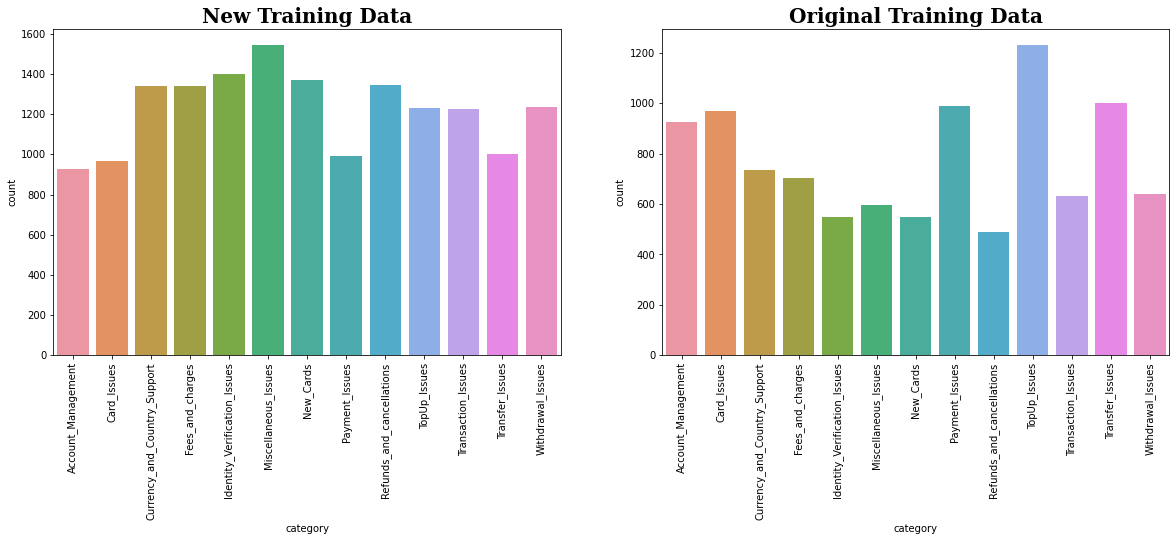

In [ ]:
# create a figure with two subplots side-by-side
category_order = categories_with_duplicates_count.category
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))

# create the barplots for dataset 1 and dataset 2 using seaborn
sns.barplot(x='category', y='count', data=categories_with_duplicates_count, order=category_order, ax=ax1)
sns.barplot(x='category', y='count', data=df_training_copy_count, order=category_order, ax=ax2)

# set titles and axis labels for each subplot
ax1.set_title('New Training Data', fontsize=20, fontfamily='serif', fontweight='bold')
ax2.set_title('Original Training Data', fontsize=20, fontfamily='serif', fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


# display the plot
plt.show()

In [ ]:
df_training_complete = df_training_concat.groupby('category').apply(lambda x: x.drop_duplicates())
df_training_complete = df_training_complete.reset_index(drop=True)

In [ ]:
df_training_complete.groupby(['category'])['category'].count().reset_index(name='count').sort_values(['count'], ascending=False)

,category,count
5,Miscellaneous_Issues,1546
4,Identity_Verification_Issues,1398
6,New_Cards,1369
8,Refunds_and_cancellations,1344
3,Fees_and_charges,1342
2,Currency_and_Country_Support,1341
12,Withdrawal_Issues,1235
9,TopUp_Issues,1232
10,Transaction_Issues,1227
11,Transfer_Issues,1001


In [ ]:
"""
# Pickle the preprocessed training data

with open('/content/drive/MyDrive/df_training_complete.pkl', 'wb') as f:   # Save to Google Drive
    pickle.dump(df_training_complete, f)   # pickle.dump(X, f) saves the preprocessed data X to a file called df_training_complete.pkl in the root directory of your Google Drive.
"""

In [ ]:
"""
# Pickle the preprocessed test dataset

with open('/content/drive/MyDrive/df_testing_copy.pkl', 'wb') as f:   # Save to Google Drive
    pickle.dump(df_testing_copy, f)   # pickle.dump(X, f) saves the preprocessed data X to a file called df_testing_copy.pkl in the root directory of your Google Drive.
"""